<a href="https://colab.research.google.com/github/Nehakumari1023/Activity-/blob/main/NLP_Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part B — News Article Classification**

Imports

In [ ]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Load news data & EDA

In [ ]:
news = pd.read_csv('data_news - data_news.csv')
news.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [ ]:
# EDA
print("Shape:", news.shape)
print("Columns:", news.columns.tolist())
print("Missing values:\n", news.isnull().sum())

Shape: (50000, 5)
Columns: ['category', 'headline', 'links', 'short_description', 'keywords']
Missing values:
 category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64


In [ ]:
# assume columns like 'text' and 'label' or 'category'
print("Category distribution:\n", news['category'].value_counts())

Category distribution:
 category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64


In [ ]:
print(news.columns)

Index(['category', 'headline', 'links', 'short_description', 'keywords'], dtype='object')


In [ ]:
news['text'] = news['headline'].astype(str) + ' ' + news['short_description'].astype(str)

news['word_count'] = news['text'].apply(lambda x: len(x.split()))
news['char_count'] = news['text'].apply(len)

news[['word_count', 'char_count']].describe()

,word_count,char_count
count,50000.000000,50000.000000
mean,32.332440,191.170700
std,13.134694,74.913628
min,4.000000,28.000000
25%,24.000000,143.000000
50%,30.000000,181.000000
75%,38.000000,221.000000
max,227.000000,1425.000000


Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    # remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # keep letters and numbers and basic punctuation; remove other weird chars
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # lowercase
    text = text.lower()
    # tokenize (simple)
    tokens = nltk.word_tokenize(text)
    # remove stopwords and short tokens, lemmatize
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return " ".join(tokens)

In [ ]:
news['clean_text'] = news['text'].astype(str).apply(clean_text)

Train/test split and TF-IDF

In [ ]:
X = news['clean_text']
y = news['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=25000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train basic classifiers & compare

In [ ]:
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'LinearSVC': LinearSVC(max_iter=5000)
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))
    print("-"*40)

Model: MultinomialNB
Accuracy: 0.8106
                precision    recall  f1-score   support

      BUSINESS       0.79      0.76      0.78      1000
 ENTERTAINMENT       0.84      0.80      0.82      1000
  FOOD & DRINK       0.84      0.88      0.86      1000
     PARENTING       0.70      0.80      0.74      1000
      POLITICS       0.80      0.75      0.77      1000
        SPORTS       0.92      0.89      0.90      1000
STYLE & BEAUTY       0.92      0.82      0.87      1000
        TRAVEL       0.80      0.82      0.81      1000
      WELLNESS       0.72      0.77      0.75      1000
    WORLD NEWS       0.81      0.82      0.82      1000

      accuracy                           0.81     10000
     macro avg       0.81      0.81      0.81     10000
  weighted avg       0.81      0.81      0.81     10000

----------------------------------------
Model: LogisticRegression
Accuracy: 0.8217
                precision    recall  f1-score   support

      BUSINESS       0.79      0.8

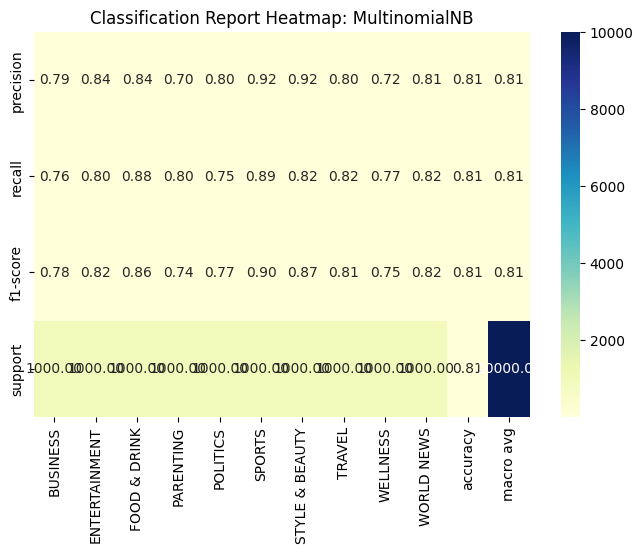

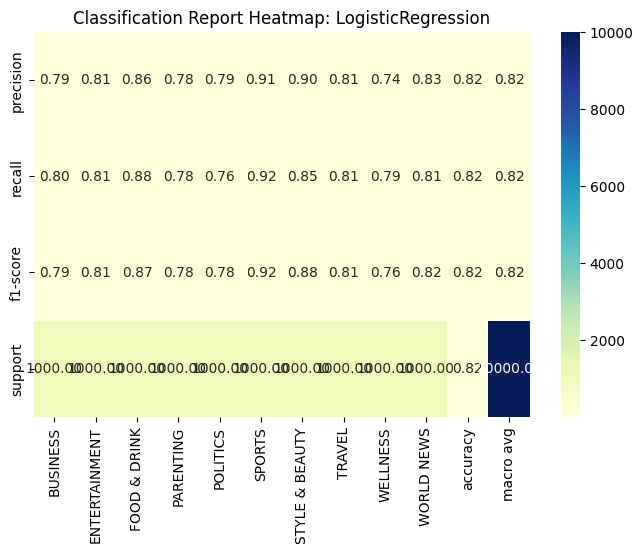

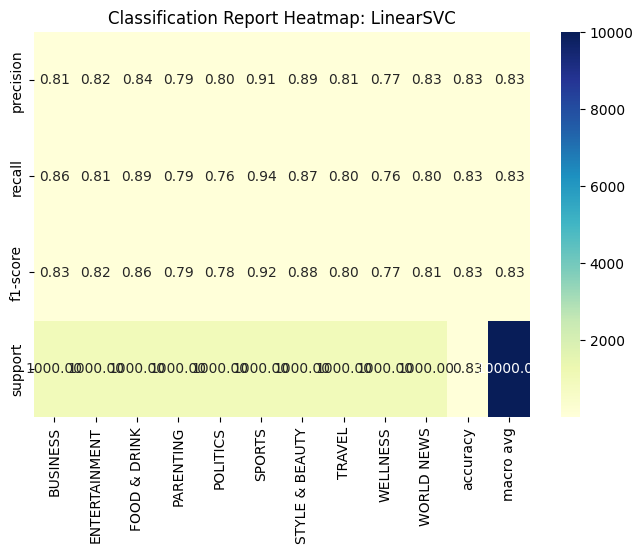

In [ ]:
from sklearn.metrics import classification_report

for name, model in models.items():
    preds = model.predict(X_test_tfidf)
    report = classification_report(y_test, preds, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(8,5))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(f'Classification Report Heatmap: {name}')
    plt.show()

Pipeline + GridSearch

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3)),
    ('clf', LogisticRegression(max_iter=2000))
])

param_grid = {
    'tfidf__max_features': [10000, 20000],
    'clf__C': [0.1, 1, 3]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='f1_macro', verbose=2)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)

best_news_model = gs.best_estimator_
preds = best_news_model.predict(X_test)
print(classification_report(y_test, preds))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 3, 'tfidf__max_features': 20000}
Best CV score: 0.8181564367777456
                precision    recall  f1-score   support

      BUSINESS       0.80      0.83      0.81      1000
 ENTERTAINMENT       0.82      0.81      0.81      1000
  FOOD & DRINK       0.86      0.88      0.87      1000
     PARENTING       0.79      0.79      0.79      1000
      POLITICS       0.79      0.77      0.78      1000
        SPORTS       0.92      0.93      0.92      1000
STYLE & BEAUTY       0.90      0.87      0.88      1000
        TRAVEL       0.81      0.81      0.81      1000
      WELLNESS       0.76      0.78      0.77      1000
    WORLD NEWS       0.83      0.80      0.81      1000

      accuracy                           0.83     10000
     macro avg       0.83      0.83      0.83     10000
  weighted avg       0.83      0.83      0.83     10000



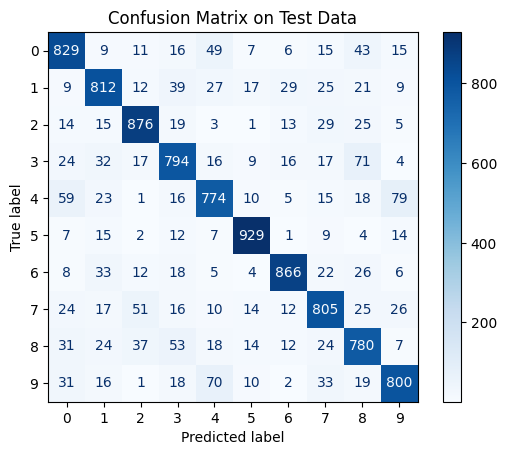

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Data")
plt.show()

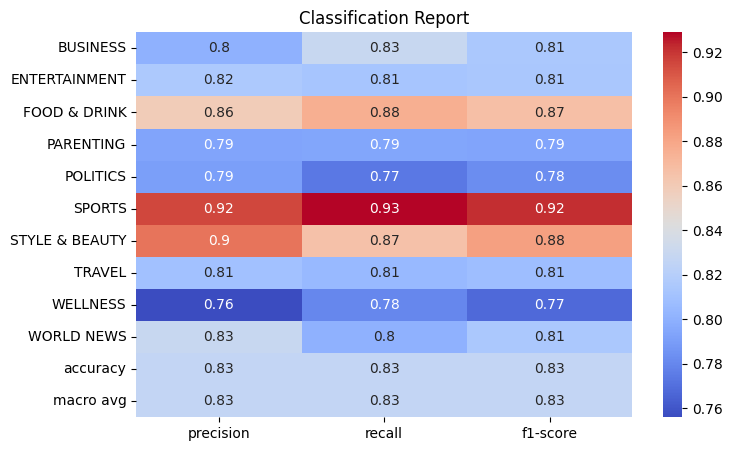

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="coolwarm")
plt.title("Classification Report")
plt.show()

Confusion matrix & feature importance per class

Top terms for class BUSINESS: ['workplace' 'financial' 'startup' 'job' 'walmart' 'uber' 'worker' 'bank'
 'marketing' 'employee' 'leadership' 'customer' 'ceo' 'company' 'business']
Top terms for class ENTERTAINMENT: ['oscar' 'show' 'box office' 'beyonc' 'netflix' 'actress' 'star' 'music'
 'album' 'jenner' 'actor' 'trailer' 'movie' 'singer' 'film']
Top terms for class FOOD & DRINK: ['cake' 'drink' 'cook' 'beer' 'restaurant' 'kitchen' 'cheese' 'photo'
 'taste' 'chef' 'cooking' 'cocktail' 'wine' 'food' 'recipe']
Top terms for class PARENTING: ['toy' 'family' 'mother' 'mommy' 'pregnancy' 'breastfeeding' 'son'
 'daughter' 'toddler' 'baby' 'parent' 'parenting' 'mom' 'child' 'kid']
Top terms for class POLITICS: ['congressman' 'immigrant' 'morning email' 'democratic' 'obamacare'
 'congress' 'fbi' 'clinton' 'senator' 'state' 'democrat' 'obama' 'senate'
 'republican' 'gop']
Top terms for class SPORTS: ['kobe' 'coach' 'athlete' 'lebron' 'fan' 'espn' 'game' 'team' 'baseball'
 'olympic' 'football' '

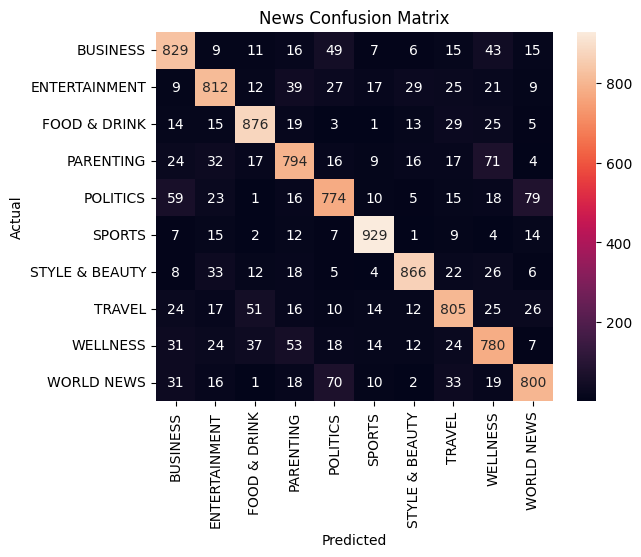

In [ ]:
cm = confusion_matrix(y_test, preds, labels=best_news_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_news_model.classes_, yticklabels=best_news_model.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('News Confusion Matrix')

# show top terms for each class (approximate using one-vs-rest coefs if using LogisticRegression)
clf = best_news_model.named_steps['clf']
vec = best_news_model.named_steps['tfidf']
if hasattr(clf, 'coef_'):
    feature_names = vec.get_feature_names_out()
    for i, cls in enumerate(clf.classes_):
        coef = clf.coef_[i]
        top_idx = np.argsort(coef)[-15:]
        print(f"Top terms for class {cls}:", feature_names[top_idx])


Save model

In [ ]:
joblib.dump(best_news_model, 'news_classification_pipeline.pkl')
print("Saved news model.")

Saved news model.


Predict new article

In [ ]:
model = joblib.load('news_classification_pipeline.pkl')
example = ["Government announces new policy for renewable energy incentives"]
print("Predicted category:", model.predict(example)[0])

Predicted category: WORLD NEWS


**Project B: News Article Classification – Conclusion**

The news classification project aimed to categorize articles into distinct topics using NLP and machine learning techniques. By cleaning, vectorizing, and analyzing the text data, the model efficiently learned to differentiate between diverse categories such as politics, sports, technology, and entertainment.
The project demonstrates the power of text analytics in automating information organization, enabling faster content filtering and better information retrieval. Overall, it reflects how supervised learning models can enhance media management systems and streamline access to relevant information in real-world applications.